In [6]:
import json
import numpy as np
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
data = sc.textFile("s3n://stat-37601/crime_data.json", minPartitions=100).map(json.loads)

In [8]:
data = data.sample(False, 0.1, 1)
n = data.count()
print n

89484


In [9]:
# define macros to index into array of attributes
ID = 0
Unix = 1
Year = 2
Month = 3
Day = 4
Hour = 5
Type = 6
Arrest = 7
Domestic = 8
Police = 9
District = 10
Ward = 11
Area = 12
Lat = 13
Longi = 14
Name = 15

(a) Plot the empirical distribution of N
(k)
(s,t),δ(x) for periods where (s, t] corresponds to each of
the 52 weeks over the last year. Use a single center and a large enough δ to cover all of
Chicago. Do the data appear to follow a Poisson distribution? What is the rate?

In [62]:
test = data.first()
print test

[6325273, 1431906300, 2015, 5, 17, 23, u'CRIMINAL DAMAGE', True, True, 1623, 16, 45, 11, 41.97623563, -87.761572388, u'JEFFERSON PARK']


In [11]:
# Compute center = mean and delta = max radius
lat_rdd = data.map(lambda x: x[Lat])
lat_mean = lat_rdd.reduce(lambda a,b: a+b)/n
lat_max = lat_rdd.reduce(lambda a,b: a if (a > b) else b)
lat_min = lat_rdd.reduce(lambda a,b: a if (a < b) else b)

longi_rdd = data.map(lambda x: x[Longi])
longi_mean = longi_rdd.reduce(lambda a,b: a+b)/n
longi_max = longi_rdd.reduce(lambda a,b: a if (a > b) else b)
longi_min = longi_rdd.reduce(lambda a,b: a if (a < b) else b)

center = (lat_mean, longi_mean)
delta = max(lat_max-lat_min,longi_max-longi_mean)
print center
print delta

(41.84138486260053, -87.6721808656905)
0.377929771


In [64]:
min_time = data.map(lambda x: x[Unix]).reduce(lambda a,b: a if (a < b) else b)
print min_time

1335124800


In [ ]:
# Count if crime satisfies given time and spatial conditions
def count(crime, center, delta, year, time_index, period):
    distance = math.sqrt((crime[Lat]-center[0])**2+(crime[Longi]-center[1])**2)
    
    begin_period = (year-1970)*3.15576*10**7
    # time_min = Unix Epoch time for beginning year + time_index*number of seconds in a day
    time_min = begin_period+time_index*period*86400 
    # period is in days
    time_max = time_min + period*86400 
    
    return crime[Unix]>time_min and crime[Unix]<time_max and distance<delta

In [66]:
print count(test, center, delta, 2014, 0, 7)
print count(test, center, delta, 2015, 19, 7)

False
True


In [67]:
period = 7 #7 days = 1 week
num_counts = 52/(period/7)
counts = []
data_subset = data.filter(lambda x: x[Year]==2014) # data in 2014
print data_subset.count()
for i in range(num_counts):
    nksum = data_subset.filter(lambda x: count(x, center, delta, 2014, i, period)).count()
    print nksum
    counts.append(nksum)
print counts

26982
372
489
485
403
519
448
427
424
456
508
510
524
552
541
533
539
502
566
519
556
525
605
558
581
572
621
576
575
556
627
588
585
594
587
587
532
512
558
543
541
446
513
523
535
466
423
422
449
490
442
470
420
[372, 489, 485, 403, 519, 448, 427, 424, 456, 508, 510, 524, 552, 541, 533, 539, 502, 566, 519, 556, 525, 605, 558, 581, 572, 621, 576, 575, 556, 627, 588, 585, 594, 587, 587, 532, 512, 558, 543, 541, 446, 513, 523, 535, 466, 423, 422, 449, 490, 442, 470, 420]


In [68]:
print "Mean rate for one week period is %d" %np.mean(counts)

Mean rate for one week period is 517


Do the data follow a Poisson distribution?

In [73]:
from scipy import stats
stats.kstest(counts, lambda x : stats.poisson.cdf(x, np.mean(counts)))

(0.2845873134455692, 0.00032077556527188023)

In [77]:
from pyspark.mllib.stat import Statistics
goodnessOfFitTestResult = Statistics.chiSqTest(counts) 
print goodnessOfFitTestResult

Chi squared test summary:
method: pearson
degrees of freedom = 51 
statistic = 372.9164156906487 
pValue = 0.0 
Very strong presumption against null hypothesis: observed follows the same distribution as expected..


From the Kolmogorov-Smirnov test for goodness of fit test and chi-squared test, it appears that the data does not follow the Poisson distribution.

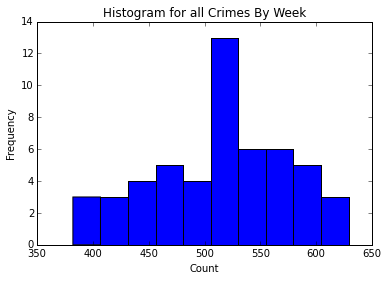

In [13]:
%matplotlib inline
plt.hist(counts)
plt.title("Histogram for all Crimes By Week")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

(b) Do the rates of the crimes scale approximately linearly as you increase or decrease the time
period (i.e. t − s)? Try increasing t − s to be 2 or 3 weeks, or decreasing it to a few days,
and observe how the distribution of counts changes. Try increasing or decreasing the spatial
radius δ. Try different centers. You don’t have to submit all the plots, but comment on the
trends you see among the different locations, spatial scales and time scales.

In [25]:
rates = [(7, np.mean(counts))]

In [26]:
# 2 weeks
counts_2 = []
for i in range(num_counts/2)*2:
    counts_2.append(counts[i]+counts[i+1])
print counts_2
rates.append((14,np.mean(counts_2)))

[827, 890, 851, 874, 924, 884, 934, 974, 981, 1015, 1013, 1069, 1066, 1030, 1045, 1021, 1047, 1075, 1053, 1076, 1167, 1188, 1147, 1147, 1157, 1216, 827, 890, 851, 874, 924, 884, 934, 974, 981, 1015, 1013, 1069, 1066, 1030, 1045, 1021, 1047, 1075, 1053, 1076, 1167, 1188, 1147, 1147, 1157, 1216]


In [27]:
# 3 weeks
counts_3 = []
for i in range(num_counts/3)*3:
    counts_3.append(counts[i]+counts[i+1]+counts[i+2])
print counts_3
rates.append((21,np.mean(counts_3)))

[1272, 1296, 1319, 1330, 1352, 1390, 1402, 1487, 1483, 1526, 1571, 1577, 1588, 1553, 1543, 1570, 1573, 1272, 1296, 1319, 1330, 1352, 1390, 1402, 1487, 1483, 1526, 1571, 1577, 1588, 1553, 1543, 1570, 1573, 1272, 1296, 1319, 1330, 1352, 1390, 1402, 1487, 1483, 1526, 1571, 1577, 1588, 1553, 1543, 1570, 1573]


In [28]:
# 4 weeks
counts_4 = []
for i in range(num_counts/4)*4:
    counts_4.append(counts[i]+counts[i+1]+counts[i+2]+counts[i+3])
print counts_4
rates.append((28,np.mean(counts_4)))

[1678, 1764, 1775, 1758, 1858, 1858, 1915, 1989, 1994, 2084, 2079, 2099, 2111, 1678, 1764, 1775, 1758, 1858, 1858, 1915, 1989, 1994, 2084, 2079, 2099, 2111, 1678, 1764, 1775, 1758, 1858, 1858, 1915, 1989, 1994, 2084, 2079, 2099, 2111, 1678, 1764, 1775, 1758, 1858, 1858, 1915, 1989, 1994, 2084, 2079, 2099, 2111]


In [29]:
print rates

[(7, 515.65384615384619), (14, 1025.8076923076924), (21, 1460.7058823529412), (28, 1920.1538461538462)]


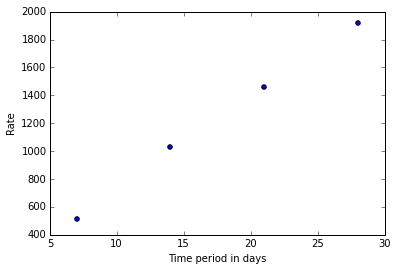

In [30]:
# Plot rates for varying time period
plt.scatter(*zip(*rates))
plt.xlabel('Time period in days')
plt.ylabel('Rate')
plt.show()

There appears to be a roughly linear relationship between the rate and time period.

In [90]:
delta = 0.378038507 #max distance between two crime points

In [91]:
# Plot rates for varying radiuses
period = 182 
num_counts = 52/(period/7)
counts_d2 = []
delta = delta/3
for i in range(num_counts):
    nksum = data.filter(lambda x: count(x, center, delta, 2014, i, period)).count()
    counts_d2.append(nksum)
print counts_d2
rates_delta = [(delta, np.mean(counts_d2))]

[9929, 10247]


In [92]:
counts_d3 = []
delta = delta/2
for i in range(num_counts):
    nksum = data.filter(lambda x: count(x, center, delta, 2014, i, period)).count()
    counts_d3.append(nksum)
print counts_d3
rates_delta.append((delta, np.mean(counts_d3)))

[3287, 3451]


In [93]:
counts_d4 = []
delta = delta/1.5
for i in range(num_counts):
    nksum = data.filter(lambda x: count(x, center, delta, 2014, i, period)).count()
    counts_d4.append(nksum)
print counts_d4
rates_delta.append((delta, np.mean(counts_d4)))

[1039, 1057]


In [94]:
counts_d5 = []
delta = delta/1.5
for i in range(num_counts):
    nksum = data.filter(lambda x: count(x, center, delta, 2014, i, period)).count()
    counts_d5.append(nksum)
print counts_d5
rates_delta.append((delta, np.mean(counts_d5)))

[349, 353]


In [95]:
counts_d6 = []
delta = delta/1.5
for i in range(num_counts):
    nksum = data.filter(lambda x: count(x, center, delta, 2014, i, period)).count()
    counts_d6.append(nksum)
print counts_d6
rates_delta.append((delta, np.mean(counts_d6)))

[160, 149]


[[0.015879234752754344, 0.003969808688188586, 0.0017643594169727047, 0.0007841597408767575, 0.00034851544038966997], (10088.0, 3369.0, 1048.0, 351.0, 154.5)]


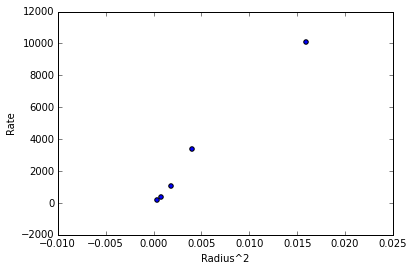

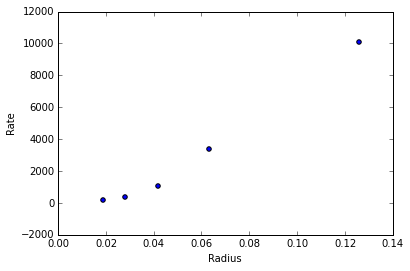

In [96]:
# Plot rates for varying time period
rates_deltas = zip(*(rates_delta))
rates_deltas[0] = [i**2 for i in rates_deltas[0]]
print rates_deltas
plt.scatter(*rates_deltas)
plt.xlabel('Radius^2')
plt.ylabel('Rate')
plt.show()
plt.scatter(*zip(*(rates_delta)))
plt.xlabel('Radius')
plt.ylabel('Rate')
plt.show()

When we first plotted the radius versus rate plot, there was a plateauing at larger radiuses and this can be explained by the non circular shape of the city. That is, when using radius = delta = maximum distance between two crime points, much of the outer region of the area we are considering will be outside the city limits and won't have any crime recorded at all. Therefore, the largest radius we use in the plot is delta/3, where we assume that the a circle around the center with radius delta/3 will be within the city limits. From the plots above, we see that the rate is roughly linearly proportional to the radius^2 as expected (number of crimes will increase linearly with area).

In [135]:
center = (41.84117892982315, -87.67203843791644)
delta = 0.378038507/3/2/1.5/1.5

In [138]:
# Plot rates for varying locations in latitude direction, fixing longitude
period = 182 
center = (center[0]+0.05, center[1])
num_counts = 52/(period/7)
counts_loc2 = []
for i in range(num_counts):
    nksum = data.filter(lambda x: count(x, center, delta, 2014, i, period)).count()
    counts_loc2.append(nksum)
print counts_loc2
rates_loc = [(center[0], np.mean(counts_loc2))]

[580, 611]


In [139]:
center = (center[0]+0.005, center[1])
num_counts = 52/(period/7)
counts_loc3 = []
for i in range(num_counts):
    nksum = data.filter(lambda x: count(x, center, delta, 2014, i, period)).count()
    counts_loc3.append(nksum)
print counts_loc3
rates_loc.append((center[0], np.mean(counts_loc3)))

[583, 600]


In [140]:
center = (center[0]-0.01, center[1])
num_counts = 52/(period/7)
counts_loc4 = []
for i in range(num_counts):
    nksum = data.filter(lambda x: count(x, center, delta, 2014, i, period)).count()
    counts_loc4.append(nksum)
print counts_loc4
rates_loc.append((center[0], np.mean(counts_loc4)))

[572, 602]


In [141]:
center = (center[0]-0.005, center[1])
num_counts = 52/(period/7)
counts_loc5 = []
for i in range(num_counts):
    nksum = data.filter(lambda x: count(x, center, delta, 2014, i, period)).count()
    counts_loc5.append(nksum)
print counts_loc5
rates_loc.append((center[0], np.mean(counts_loc5)))

[609, 616]


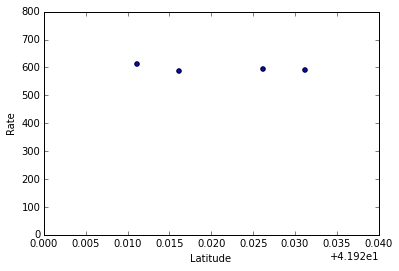

In [145]:
# Plot rates for different centers
plt.scatter(*zip(*(rates_loc)))
plt.xlabel('Latitude')
plt.ylabel('Rate')
plt.ylim((0,800))
plt.show()

The crime rate appears to be roughly uniform at different centers

Part (c) Analyze the rate of occurrence of a particular crime type, and check if the “interarrival times”
between crimes roughly follow an exponential distribution with the appropriate rate.

In [6]:
print test[Type]=='CRIMINAL DAMAGE'

True


In [7]:
data_cd = data.filter(lambda x: x[Type]=='CRIMINAL DAMAGE').map(lambda x: x[Unix])
cd_times = data_cd.collect()
print len(cd_times)

9382


In [8]:
cd_times = sorted(cd_times)
cd_diff = [j-i for i, j in zip(cd_times[:-1], cd_times[1:])]

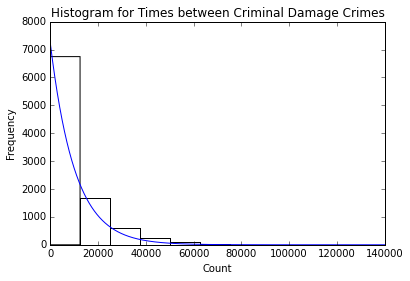

In [54]:
%matplotlib inline
from scipy import stats
from scipy.stats import expon
param = stats.expon.fit(cd_diff)
plt.hist(cd_diff, color='w')
x = np.linspace(0,140000,10000)
y = expon.pdf(x, *param)*7500/(0.0001)
plt.plot(x,y)
plt.title("Histogram for Times between Criminal Damage Crimes")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

In [48]:
from scipy import stats
stats.kstest(cd_diff, lambda x: stats.expon.cdf(x, *param))

(0.060718649892721799, 1.8217782365617367e-30)

From the Kolmogorov-Smirnov test for goodness of fit, since the p-value is close to 0, we conclude that the values do not perfectly fit an exponential distribution. However, from the histogram, it appears that an exponential distribution can approximate it quite well.

(d) Estimate a Poisson model using data selected from 2010 through 2014 using several choices of δ for each of the cluster centers. How well does the model predict crime in 2015? Does the model improve the more past data that you use? What are the trade-offs you observe?

In [5]:
# estimate poisson model, train on 2010-2014; first find lambda
train_set = data.filter(lambda x: x[Year]==2014 or x[Year]==2013 or x[Year]==2012 or x[Year]==2010)
train_set.count()

80447

In [6]:
train_set.first()

[6230758,
 1420068420,
 2014,
 12,
 31,
 23,
 u'LIQUOR LAW VIOLATION',
 True,
 True,
 111,
 1,
 42,
 32,
 41.886490925,
 -87.624678141,
 u'LOOP']

In [26]:
import math
import numpy as np
def gauss_kernel(x, y):
    u = np.subtract(x, y)
    b = math.sqrt(2*math.pi)
    w = np.zeros(len(u))
    for i in range(len(u)):
        w = math.exp(0.5 * math.pow(np.linalg.norm(u), 2))         
    return w
gauss_kernel([5, 2], [2,1])    

148.41315910257674

In [82]:
# s is the center?
# lambda_s = sum over i, j[K(si, s) Nij]
#          / sum over i, j[k(si, s) * tij * A
# Process is poisson w/ rate lambda_s * A
def trainPoisson(train, center, delta):
    lambda_top = 0.0
    lambda_bottom = 0.0
    A = delta * delta * math.pi
    # earliest data is from 2012
    for year in [2012, 2013, 2014]:
        periods = [21.0]
        for period in periods:
            num_counts = int(52/(period/7))
            for i in range(num_counts):
                valid = train.filter(lambda x: count(x, center, delta, year, i, period))
                if valid.count() == 0:
                    pass
                else:
                    kernel_sum = valid.map(lambda x: gauss_kernel((x[Lat],x[Longi]), center))
                    kernel_sum.first()
                    kernel_sum = kernel_sum.reduce(lambda a, b: a+b)
                    lambda_top += kernel_sum
                    distinct_pts = valid.map(lambda x: (x[Lat],x[Longi])).distinct()
                    bottom_sum = distinct_pts.map(lambda x: gauss_kernel(x, center)).reduce(lambda a, b: a+b)
                    bottom_sum = bottom_sum * period * A
                    lambda_bottom += bottom_sum
    P_lambda = lambda_top / lambda_bottom
        
    return P_lambda

a few estimates for lambda based on 2010-2014 data:

In [48]:
# LARGE AREA, period is 182 days
actual_center = (41.84117892982315, -87.67203843791644)
max_delta = 0.378038507

test_lambda = trainPoisson(train_set, actual_center, max_delta)

In [1]:
test_lambda * 365

12546.2749602814

In [63]:
# SMALL AREA - is this estimate better or worse?
actual_center = (41.84117892982315, -87.67203843791644)
delta_5 = 0.05

test_lambda_2 = trainPoisson(train_set, actual_center, delta_5)

A = delta_5 * delta_5 * math.pi
test_lambda_2 * A

0.006062938448227665

In [2]:
test_lambda_2 * 365

21496.29385023

In [ ]:
# changed period to 21, small area
test_lambda_3 = trainPoisson(train_set, actual_center, delta_5)
A = delta_5 * delta_5 * math.pi
test_lambda_3 * A

In [3]:
data.filter(lambda x: x[Year] == 2015).count()

9037

The model trained on 2012-2014 is not a great model for predicting crimes in 2015 using the parameters above. By using more data, the model better approximates the train data, but that does not reflect the 2015 data, which has a lower rate than other years. Thus including more data did not necessarily improve the model. <br> <br>
(e) Suppose we merge two crime types (say BATTERY and BURGLARY or CRIMINAL DAMAGE and THEFT. Is the number of combined crimes for the two types again an (approximate) Poisson process? Is the new rate close to the sum of the original rates? Comment on your findings.

In [1]:
num_counts = 52/(period/7)
counts = []
data_subset = data.filter(lambda x: x[Type]=='BATTERY')
for i in range(num_counts):
    nksum = data_subset.filter(lambda x: count(x, center, delta, 2014, i, period)).count()
    counts.append(nksum)
np.mean(counts)

96.13461538461539

In [2]:
from scipy import stats
stats.kstest(counts, lambda x : stats.poisson.cdf(x, np.mean(counts)))

(0.19272489468386678, 0.036330805982025316)

In [3]:
num_counts = 52/(period/7)
counts = []
data_subset = data.filter(lambda x: x[Type]=='CRIMINAL DAMAGE') 
for i in range(num_counts):
    nksum = data_subset.filter(lambda x: count(x, center, delta, 2014, i, period)).count()
    counts.append(nksum)
np.mean(counts)

52.34615384615385

In [4]:
from scipy import stats
stats.kstest(counts, lambda x : stats.poisson.cdf(x, np.mean(counts)))

(0.09460242504334665, 0.7418756218492246)

In [5]:
num_counts = 52/(period/7)
counts = []
data_subset = data.filter(lambda x: x[Type]=='CRIMINAL DAMAGE' or x[Type]=='BATTERY') 
for i in range(num_counts):
    nksum = data_subset.filter(lambda x: count(x, center, delta, 2014, i, period)).count()
    counts.append(nksum)
np.mean(counts)

148.48076923076923

In [8]:
from scipy import stats
stats.kstest(counts, lambda x : stats.poisson.cdf(x, np.mean(counts)))

(0.25028500988599756, 0.002342674358980501)

From the Kolmogorov-Smirnov test for goodness of fit, it seems that since we have a p-value <0.01, the new rate is not close to the sum of the two old rates. This may be because the counts for crimes of type battery do not follow a poisson process very well in the first place, with a p-value of 0.04, and the counts for crimes of type criminal damage do not follow a poisson process at all.

<b>Part 2</b> We use k-means clustering to cluster the neighborhoods based on the crime rate proportions. First, we find the crime rates for each crime type in every neighborhood. Then we divided the crime rates by the total number of crimes in each neighborhood to get the crime rate proportions. We then cluster the neighborhoods based on the crime rate proportions, using 15 clusters. The neighborhoods are labeled with their cluster number. We see that neighborhoods next to each other do tend to be grouped in the same clusters, such as neighborhoods in the South Side (cluster = 0)

In [16]:
import json
import urllib2
from matplotlib.path import Path

communities = json.load(urllib2.urlopen("https://s3.amazonaws.com/stat-37601/communities.json"))

def get_community_of(lat, lon):
    for community in communities:
        path = Path(community['coordinates'])
        if path.contains_point([lon, lat]):
            return community['name']


In [17]:
get_community_of(center[0],center[1])

u'LOWER WEST SIDE'

In [18]:
import collections

In [19]:
comm_rdd = data.map(lambda x: (get_community_of(x[Lat],x[Longi]), x[Type]))
comm_list = comm_rdd.collect()

In [20]:
# type_set is list of crime types
type_list = [x[1] for x in comm_list]
type_set = set(type_list)

In [21]:
# name_set is list of neighborhood names
name_list = [x[0] for x in comm_list]
name_set = set(name_list)

In [22]:
# Create a dictionary for each neighborhood, then get proportional counts for each neighborhood
counter_list = []
for name in name_set:
    total = 0
    counts = {key: int(0) for key in type_set}
    for crime in comm_list:
        if crime[0] == name:
            counts[crime[1]]+=1
            total = total+1
    proportions = [float(x)/total for x in counts.values()]
    counter_list.append((name, proportions))
print counter_list[0]

(u'CALUMET HEIGHTS', [0.0, 0.0, 0.0, 0.008620689655172414, 0.0, 0.0, 0.0, 0.040948275862068964, 0.08836206896551724, 0.01939655172413793, 0.0, 0.0, 0.06465517241379311, 0.14655172413793102, 0.24568965517241378, 0.004310344827586207, 0.0, 0.0, 0.0, 0.0, 0.036637931034482756, 0.0021551724137931034, 0.0, 0.0, 0.04741379310344827, 0.16379310344827586, 0.0, 0.004310344827586207, 0.05818965517241379, 0.0625, 0.00646551724137931, 0.0])


Cluster crime proportions with k-means

In [23]:
from pyspark.mllib.clustering import KMeans
counter_rdd = sc.parallelize(counter_list)
clusters = KMeans.train(counter_rdd.map(lambda x: x[1]), 15, maxIterations=50, runs=10, initializationMode="random")

In [30]:
labels = counter_rdd.map(lambda x: (x[0], clusters.predict(x[1]))).collect()
#print labels

In [25]:
from collections import defaultdict
label_groups = defaultdict(list)
for v, k in labels: 
    label_groups[k].append(v)
    
import pprint
pprint.pprint(label_groups.items())

[(0,
  [u'SOUTH LAWNDALE',
   u'ROSELAND',
   u'CHICAGO LAWN',
   u'SOUTH SHORE',
   u'RIVERDALE',
   u'AUBURN GRESHAM',
   u'SOUTH CHICAGO',
   u'ENGLEWOOD',
   u'WASHINGTON PARK',
   u'WEST PULLMAN',
   u'GRAND BOULEVARD',
   u'WEST ENGLEWOOD',
   u'WOODLAWN',
   u'GREATER GRAND CROSSING',
   u'NEW CITY']),
 (1, [u'BEVERLY', u'MOUNT GREENWOOD', u'NORTH PARK', u'FOREST GLEN']),
 (2,
  [u'HUMBOLDT PARK',
   u'WEST GARFIELD PARK',
   u'NORTH LAWNDALE',
   u'EAST GARFIELD PARK',
   u'AUSTIN']),
 (3, [None]),
 (4, [u'NEAR NORTH SIDE', u'LOOP']),
 (5,
  [u'EAST SIDE',
   u'HEGEWISCH',
   u'LOWER WEST SIDE',
   u'ALBANY PARK',
   u'PULLMAN',
   u'HERMOSA',
   u'BRIGHTON PARK',
   u'OAKLAND',
   u'GAGE PARK']),
 (6,
  [u'CALUMET HEIGHTS',
   u'IRVING PARK',
   u'AVONDALE',
   u'ASHBURN',
   u'BRIDGEPORT',
   u'EDISON PARK',
   u'CLEARING',
   u'GARFIELD RIDGE',
   u'DUNNING',
   u'WEST ELSDON']),
 (7, [u'DOUGLAS', u'UPTOWN', u'CHATHAM', u'FULLER PARK', u'ARMOUR SQUARE']),
 (8,
  [u'LINCOLN S

Create KML file (using code provided)

In [26]:
# KML downloaded from : https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6
# KML to JSON converted at : http://ogre.adc4gis.com/
# communities.json has been postprocessed to remove irrelevant fields/data
import json;
from matplotlib.path import Path;
with open('communities.json') as infile:
    communities=json.load(infile);
def getCommunityName(lat, lng, communities):
    'Assumption: (lat,lng) is not out of scope'
    for i in range(len(communities)):
        path=Path(communities[i]['coordinates']);
        # Path requires points to be ordered along the boundary of the polygon.
        if(path.contains_point([lng,lat])):
            return communities[i]['name'];
    return 'OUTSIDE';

In [27]:
# Original KML file with colors downloaded from http://reallyboring.net/?page_id=16
import xml.etree.ElementTree as ET
ET.register_namespace("","http://www.opengis.net/kml/2.2")
tree = ET.parse('communities.kml')
root = tree.getroot()[0]
def fillCommunityHovertext(name, text):
    for placemark in root.iter('{http://www.opengis.net/kml/2.2}Placemark'):
        if placemark[0].text == name : # corresponds to tag 'name'
            placemark[1].text = text; # corresponds to tag 'description'

In [29]:
for item in labels:
    fillCommunityHovertext(str(item[0]),str(item[1]));
    tree.write('communities_updated.kml','UTF-8')